In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.inspection import permutation_importance

In [2]:
data = pd.read_csv("ExecutionAlgoData.csv")

In [3]:
data.shape

(69212, 29)

In [4]:
data.dropna(inplace=True)
data.drop(['BTP_PlacementID'],axis=1,inplace=True)

In [5]:
i=0
while i < 3:
    if i == 0:
        data['BTP_TradeDateEST_day'] = pd.to_datetime(data['BTP_TradeDateEST']).dt.day
    elif i == 1:
        data['BTP_TradeDateEST_month'] = pd.to_datetime(data['BTP_TradeDateEST']).dt.month
    else:
        data['BTP_TradeDateEST_year'] = pd.to_datetime(data['BTP_TradeDateEST']).dt.year
    i += 1

In [6]:
data.drop(['BTP_TradeDateEST'],axis=1,inplace=True)

In [7]:
for col in ['BTP_Broker','BTP_Strategy','BTP_Desk','BTP_Trader','BTP_OrderType']:
    ohe = OneHotEncoder(sparse=False)
    x = pd.DataFrame(ohe.fit_transform(data[col].to_numpy().reshape(-1,1)))
    for cols in x.columns:
        data[col+'_ohe_'+str(cols)] = x[cols]
    #with open('models/one_hot_encoding_'+col+".bin","wb") as f:
        #pickle.dump(ohe, f)
    data.drop([col],axis=1,inplace=True)

In [8]:
data.dropna(inplace=True)

In [9]:
data['BTP_Side'] = data['BTP_Side'].apply(lambda a:int(a == 'S'))

In [10]:
i=0
t1 = pd.to_datetime(data['BTP_StartTime'])
while i < 6:
    if i == 0:
        data['BTP_StartTime_day'] = t1.dt.day
    elif i == 1:
        data['BTP_StartTime_month'] = t1.dt.month
    elif i == 2:
        data['BTP_StartTime_year'] = t1.dt.year
    elif i == 3:
        data['BTP_StartTime_hour'] = t1.dt.hour
    elif i == 4:
        data['BTP_StartTime_minute'] = t1.dt.minute
    else:
        data['BTP_StartTime_second'] = t1.dt.second
    i += 1
data.drop(['BTP_StartTime'],axis=1,inplace=True)

In [11]:
data.shape

(33485, 131)

In [12]:
(data.dtypes == 'float64').sum(), (data.dtypes == 'int64').sum(), (data.dtypes == 'object').sum()

(121, 10, 0)

In [13]:
x = data.drop(['BTP_LmtAdjArrivalPrice_bps','BTP_LmtAdjPWP20Pct_bps'],axis=1)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x,data.BTP_LmtAdjPWP20Pct_bps,test_size=0.2)

In [97]:
x_scaler = StandardScaler()
x_train_std = x_scaler.fit_transform(x_train)
x_test_std = x_scaler.transform(x_test)

y_scaler = StandardScaler()
y_train_std = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_std = y_scaler.transform(y_test.to_numpy().reshape(-1, 1))

In [108]:
model = Sequential()
model.add(Dense(25, input_dim=x_train.shape[1], activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(5, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(1, activation='linear'))

In [109]:
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
model.fit(x_train_std,y_train_std,epochs=10,verbose=1,batch_size=4,validation_split=0.2)

Epoch 1/10
5693/5693 [==============================] - 12s 2ms/step - loss: 0.9101 - val_loss: 0.6393
Epoch 2/10
5693/5693 [==============================] - 11s 2ms/step - loss: 0.8248 - val_loss: 0.5949
Epoch 3/10
5693/5693 [==============================] - 13s 2ms/step - loss: 0.7642 - val_loss: 0.5586
Epoch 4/10
5693/5693 [==============================] - 11s 2ms/step - loss: 0.7151 - val_loss: 0.5443
Epoch 5/10
5693/5693 [==============================] - 11s 2ms/step - loss: 0.6814 - val_loss: 0.5308
Epoch 6/10
5693/5693 [==============================] - 10s 2ms/step - loss: 0.6487 - val_loss: 0.5202
Epoch 7/10
5693/5693 [==============================] - 10s 2ms/step - loss: 0.6250 - val_loss: 0.5128
Epoch 8/10
5693/5693 [==============================] - 10s 2ms/step - loss: 0.6013 - val_loss: 0.5115
Epoch 9/10
5693/5693 [==============================] - 10s 2ms/step - loss: 0.5845 - val_loss: 0.5068
Epoch 10/10
5693/5693 [==============================] - 10s 2ms/step - l

In [113]:
#dir(model)

In [114]:
r2_score(y_train_std,model.predict(x_train_std))

0.4761402634040952

In [115]:
r2_score(y_test_std,model.predict(x_test_std))

0.34314929693735174

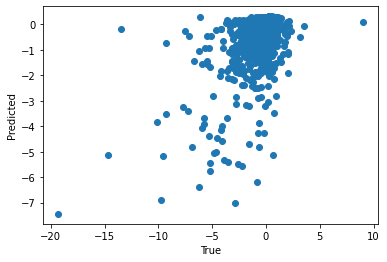

In [116]:
plt.scatter(y_test_std,model.predict(x_test_std).reshape(1,-1)[0])
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

In [119]:
results = permutation_importance(model, x_test_std, y_test_std, scoring='neg_mean_squared_error')
importance = results.importances_mean

<AxesSubplot:xlabel='features'>

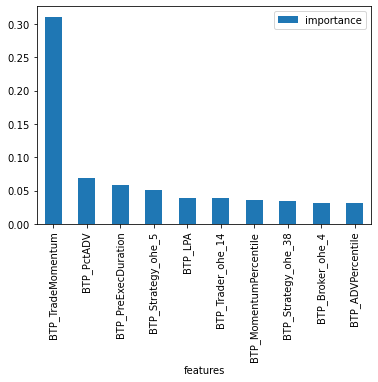

In [133]:
t1 = pd.DataFrame(importance,columns=['importance'])
t1['features'] = x_train.columns

t1.sort_values(['importance'],ascending=False).reset_index().iloc[:10].plot(x='features',y='importance',kind='bar')